In [1]:
#from tensorflow import keras
#from tensorflow.keras import layers
import numpy as np
import pylab as plt
import os
import cv2
import pandas as pd 
import gc
import keras as k
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, TimeDistributed
from keras.layers import Conv2D, MaxPooling2D, ConvLSTM2D, Conv3D, Reshape, LSTM
from sklearn.metrics import fbeta_score
from tqdm import tqdm

In [2]:
import pathlib
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# build conv lstm training data
seq_train = np.load("/content/drive/My Drive/Colab Notebooks/FYP/seq_train.npy")
split = 45   # split 40 images for validation
test = 5    # save 5 images for testing
x_train = seq_train[:, :12, :, :, :]
y_train = seq_train[:, 12:, :, :, :]
x_train, x_valid, y_train, y_valid, x_test, y_test  = x_train[split:], x_train[5:split], y_train[split:], y_train[5:split], x_train[:5], y_train[:5]

In [5]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((188, 12, 20, 20, 17),
 (40, 12, 20, 20, 17),
 (188, 1, 20, 20, 17),
 (40, 1, 20, 20, 17))

In [6]:
# define our model
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization

model = Sequential()
model.add(ConvLSTM2D(filters=32, input_shape=(None, 20, 20, 17),kernel_size=(5, 5), padding="same", return_sequences=True, activation="relu"))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True, activation="relu"))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=32, kernel_size=(1, 1), padding="same", return_sequences=True, activation="relu"))
model.add(tf.keras.layers.Reshape((1, 20, 20, 384), input_shape=(None,20, 20, 32)))
model.add(Conv3D(filters=17, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"))



In [7]:
model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, None, 20, 20, 32)  156928    
                                                                 
 batch_normalization (BatchN  (None, None, 20, 20, 32)  128      
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 20, 20, 32)  73856     
                                                                 
 batch_normalization_1 (Batc  (None, None, 20, 20, 32)  128      
 hNormalization)                                                 
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, None, 20, 20, 32)  8320      
                                                                 
 reshape (Reshape)           (None, 1, 20, 20, 384)    0

In [10]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(x_valid, y_valid))

Epoch 1/20
6/6 [==============================] - 2s 284ms/step - loss: 0.1981 - accuracy: 0.5409 - val_loss: 0.2830 - val_accuracy: 0.5296
Epoch 2/20
6/6 [==============================] - 1s 236ms/step - loss: 0.1984 - accuracy: 0.5418 - val_loss: 0.2779 - val_accuracy: 0.5296
Epoch 3/20
6/6 [==============================] - 1s 242ms/step - loss: 0.1972 - accuracy: 0.5565 - val_loss: 0.2708 - val_accuracy: 0.5296
Epoch 4/20
6/6 [==============================] - 1s 237ms/step - loss: 0.1971 - accuracy: 0.5431 - val_loss: 0.2698 - val_accuracy: 0.5296
Epoch 5/20
6/6 [==============================] - 1s 246ms/step - loss: 0.1988 - accuracy: 0.5493 - val_loss: 0.2615 - val_accuracy: 0.5296
Epoch 6/20
6/6 [==============================] - 1s 239ms/step - loss: 0.1980 - accuracy: 0.5450 - val_loss: 0.2649 - val_accuracy: 0.5296
Epoch 7/20
6/6 [==============================] - 2s 265ms/step - loss: 0.1971 - accuracy: 0.5414 - val_loss: 0.2601 - val_accuracy: 0.5296
Epoch 8/20
6/6 [====

In [47]:
model.evaluate(x_valid, y_valid)

2/2 [==============================] - 0s 32ms/step - loss: 0.2569 - accuracy: 0.5296


[0.2569196820259094, 0.5296249985694885]

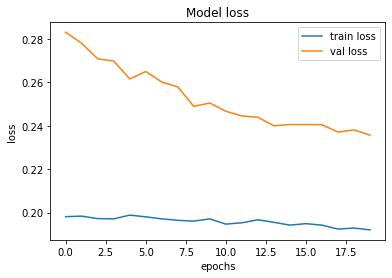

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'])
plt.show()


In [13]:
label_map = {'agriculture': 1,
 'artisinal_mine': 5,
 'bare_ground': 0,
 'blooming': 16,
 'blow_down': 12,
 'clear': 6,
 'cloudy': 14,
 'conventional_mine': 15,
 'cultivation': 7,
 'habitation': 10,
 'haze': 3,
 'partly_cloudy': 4,
 'primary': 2,
 'road': 8,
 'selective_logging': 11,
 'slash_burn': 9,
 'water': 13}
 
def get_labels(preds):
  tags = []
  for ind, t  in enumerate(preds):
    if t > 0.2:
      for l in label_map:
        if label_map[l] == ind:
          tags.append(l)
  return tags

In [57]:
p_grid = []   # predictions made by the ConvLSTM model
t_grid = []   # labels predicted by the CNN model 
label = "road"
img = cv2.imread("/content/drive/My Drive/Colab Notebooks/FYP/Sequences1/1_2022-01-01.tif")
# get the predictions for test image
for row in range(20):
  t_grid_row = []
  p_grid_row = []
  for col in range(20):
    preds = predictions[1, 0, row, col]
    true = y_test[1, 0, row, col]
    preds_text = get_labels(preds)
    true_text = get_labels(true)
    if label in preds_text:
      p_grid_row.append(1)
    else:
      p_grid_row.append(0)
    if label in true_text:
      t_grid_row.append(1)
    else:
      t_grid_row.append(0)
    p_grid.append(p_grid_row)
    t_grid.append(t_grid_row)


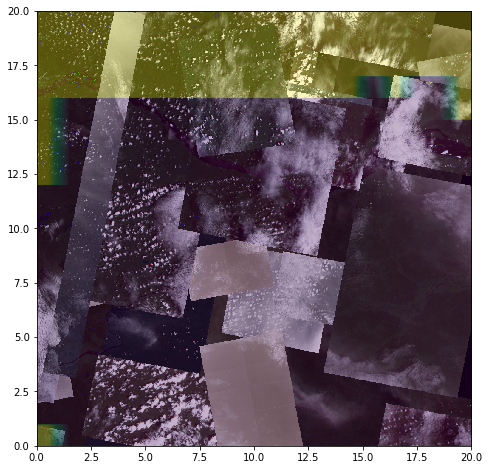

In [59]:
import matplotlib.pyplot as plt
# plot the map layer above the image
extent = 0, 20, 0, 20
fig = plt.figure(frameon=False, figsize=(8, 8))

im1 = plt.imshow(img, cmap=plt.cm.gray, interpolation='nearest', extent=extent)

im2 = plt.imshow(p_grid, cmap=plt.cm.viridis, alpha=.3, interpolation='bilinear', extent=extent)
plt.show()